In [1]:
import csv
import pandas as pd
import numpy as np

In [2]:
#데이터 가져오기
labels = pd.read_csv("../data/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
#이미지 파일 데이터 라벨에 집어넣기
filePath = '../data/train/'
f = lambda x: filePath + x + '.jpg'

labels['imgpath'] = labels['id'].apply(f)

In [4]:
labels.head()

,id,breed,imgpath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../data/train/000bec180eb18c7604dcecc8fe0dba07...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../data/train/001513dfcb2ffafc82cccf4d8bbaba97...
2,001cdf01b096e06d78e9e5112d419397,pekinese,../data/train/001cdf01b096e06d78e9e5112d419397...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../data/train/00214f311d5d2247d5dfe4fe24b2303d...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../data/train/0021f9ceb3235effd7fcde7f7538ed62...


In [5]:
from PIL import Image
import os

#이미지 객로로 변환
def load_image(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size) #이미지 크기
    return img

#데이터 프레임의 이미지 파일 경로 사용하여 이미지로드하고 객체전환
target_size = (100, 100)
labels['image_path'] = labels['imgpath'] #새로운열로 이미지저장
labels['image'] = labels['image_path'].apply(lambda x: load_image(x, target_size)) #apply 행에 함수를 적용하고 결과를 반환

#데이터 프레임 저장시 이미지 열제거
labels.drop('image_path', axis=1, inplace=True)

#이미지 객체를 별도의 이미지 파일로 저장

In [16]:
labels.head()

,id,breed,imgpath,image
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../data/train/000bec180eb18c7604dcecc8fe0dba07...,<PIL.Image.Image image mode=RGB size=100x100 a...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../data/train/001513dfcb2ffafc82cccf4d8bbaba97...,<PIL.Image.Image image mode=RGB size=100x100 a...
2,001cdf01b096e06d78e9e5112d419397,pekinese,../data/train/001cdf01b096e06d78e9e5112d419397...,<PIL.Image.Image image mode=RGB size=100x100 a...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../data/train/00214f311d5d2247d5dfe4fe24b2303d...,<PIL.Image.Image image mode=RGB size=100x100 a...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../data/train/0021f9ceb3235effd7fcde7f7538ed62...,<PIL.Image.Image image mode=RGB size=100x100 a...


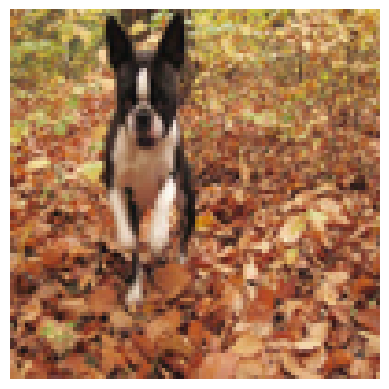

In [6]:
#이미지 확인해보기
import matplotlib.pyplot as plt
image = labels['image'].iloc[0]

plt.imshow(image)
plt.axis('off') # 축 끄기
plt.show()

In [17]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       10222 non-null  object
 1   breed    10222 non-null  object
 2   imgpath  10222 non-null  object
 3   image    10222 non-null  object
dtypes: object(4)
memory usage: 319.6+ KB


In [7]:
#데이터 전처리
# 데이터프레임의 이미지를 배열로 변환
X = np.array([np.array(img) for img in labels['image']])
#X_train = labels['image'].values / 255
X = X / 255.0

In [8]:
# Y 만들기
from sklearn.preprocessing import LabelEncoder

# 라벨인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels['breed'])

# 클래스 개수 확인
num_classes = len(label_encoder.classes_)

In [9]:
print(num_classes)

120


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

image_height = 100  # 이미지 높이
image_width = 100  # 이미지 너비
channels = 3  # 이미지 채널 수 (RGB 이미지의 경우 3)

# CNN 모델 구성
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, channels)), #Conv2D
    layers.MaxPooling2D(pool_size=(2, 2)), # MaxPooling2D 2개 정수의 튜플, 축소인수 ex 두 공간차원에 대한 반으로 축소
    layers.Dropout(0.25), #Dropout 과적합 방지
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(), # 입력 데이터를 1차원으로 평탄화
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10
256/256 [==============================] - 65s 253ms/step - loss: 4.7889 - accuracy: 0.0088 - val_loss: 4.7838 - val_accuracy: 0.0068
Epoch 2/10
256/256 [==============================] - 61s 238ms/step - loss: 4.7676 - accuracy: 0.0122 - val_loss: 4.7760 - val_accuracy: 0.0132
Epoch 3/10
256/256 [==============================] - 61s 239ms/step - loss: 4.7401 - accuracy: 0.0163 - val_loss: 4.7530 - val_accuracy: 0.0122
Epoch 4/10
256/256 [==============================] - 62s 243ms/step - loss: 4.6979 - accuracy: 0.0220 - val_loss: 4.7180 - val_accuracy: 0.0210
Epoch 5/10
256/256 [==============================] - 63s 244ms/step - loss: 4.6421 - accuracy: 0.0229 - val_loss: 4.6901 - val_accuracy: 0.0210
Epoch 6/10
256/256 [==============================] - 64s 251ms/step - loss: 4.6007 - accuracy: 0.0269 - val_loss: 4.6587 - val_accuracy: 0.0269
Epoch 7/10
256/256 [==============================] - 62s 241ms/step - loss: 4.5632 - accuracy: 0.0342 - val_loss: 4.6386 - val_ac

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 64)        0

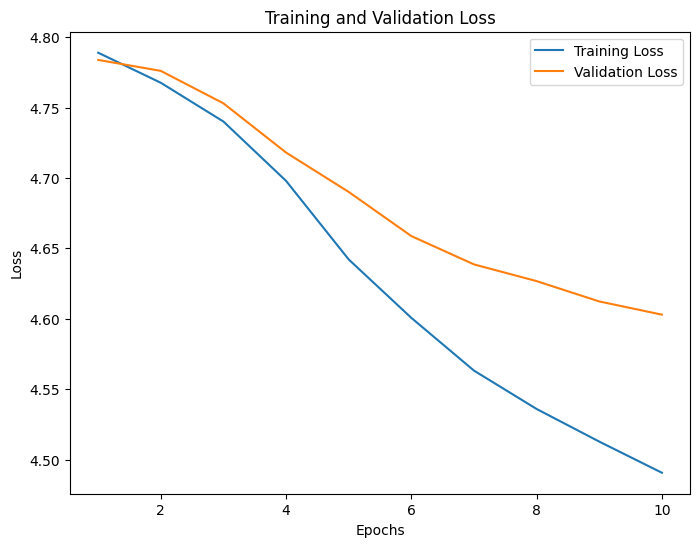

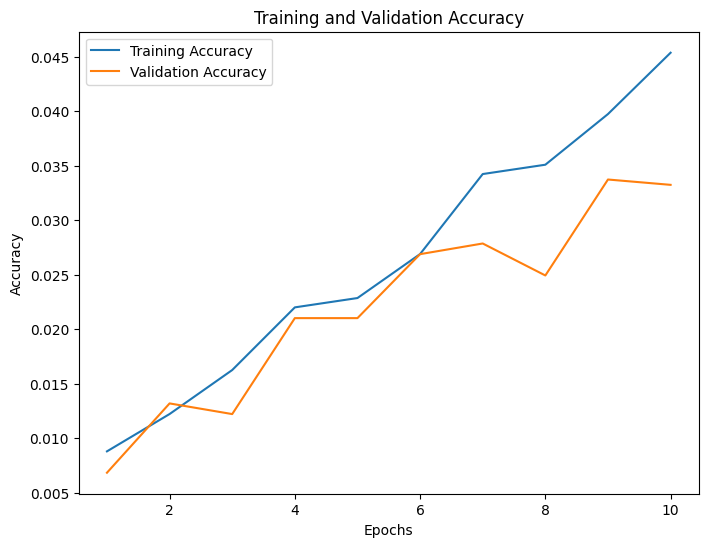

In [13]:
#손실, 정확도 그래프 그리기
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), history.history['loss'], label='Training Loss')
plt.plot(range(1, 11), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, 11), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

image_height = 100  # 이미지 높이
image_width = 100  # 이미지 너비
channels = 3  # 이미지 채널 수 (RGB 이미지의 경우 3)

# CNN 모델 구성
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, channels)), #Conv2D
    layers.MaxPooling2D(pool_size=(2, 2)), # MaxPooling2D 2개 정수의 튜플, 축소인수 ex 두 공간차원에 대한 반으로 축소
    layers.Dropout(0.25), #Dropout 과적합 방지
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(), # 입력 데이터를 1차원으로 평탄화
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10
256/256 [==============================] - 68s 263ms/step - loss: 4.7858 - accuracy: 0.0125 - val_loss: 4.7577 - val_accuracy: 0.0127
Epoch 2/10
256/256 [==============================] - 64s 249ms/step - loss: 4.6073 - accuracy: 0.0268 - val_loss: 4.5646 - val_accuracy: 0.0279
Epoch 3/10
256/256 [==============================] - 64s 250ms/step - loss: 4.3471 - accuracy: 0.0509 - val_loss: 4.4031 - val_accuracy: 0.0499
Epoch 4/10
256/256 [==============================] - 65s 252ms/step - loss: 4.0688 - accuracy: 0.0843 - val_loss: 4.3690 - val_accuracy: 0.0567
Epoch 5/10
256/256 [==============================] - 68s 265ms/step - loss: 3.7084 - accuracy: 0.1479 - val_loss: 4.4801 - val_accuracy: 0.0592
Epoch 6/10
256/256 [==============================] - 67s 263ms/step - loss: 3.2714 - accuracy: 0.2277 - val_loss: 4.5923 - val_accuracy: 0.0523
Epoch 7/10
256/256 [==============================] - 64s 250ms/step - loss: 2.7576 - accuracy: 0.3326 - val_loss: 5.0096 - val_ac

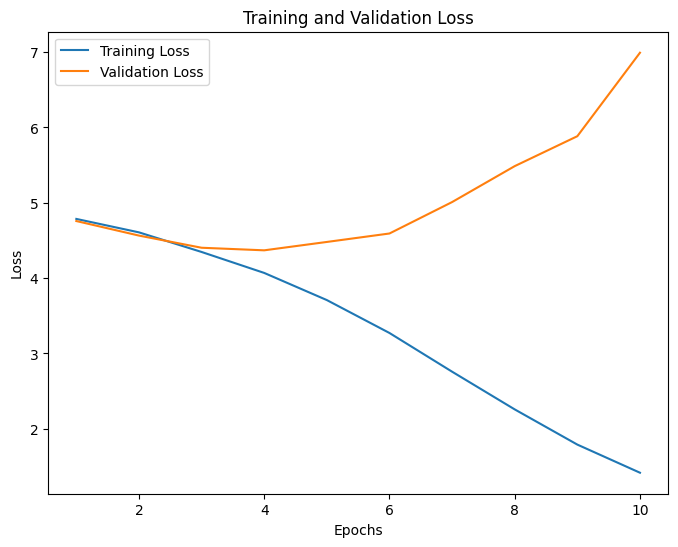

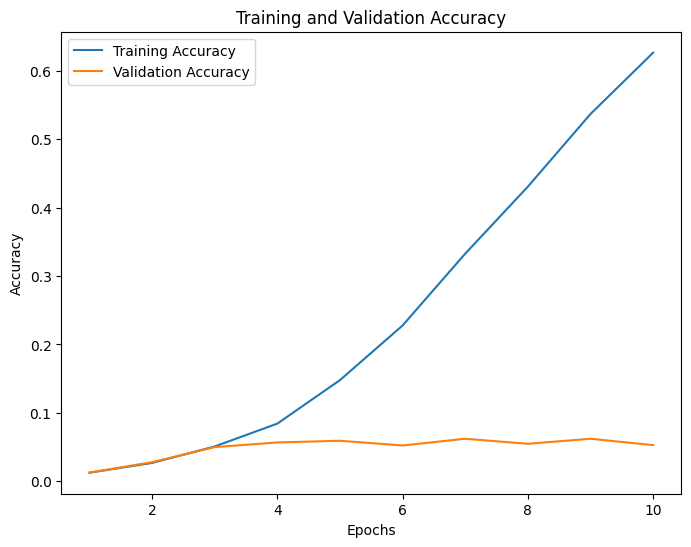

In [16]:
#손실, 정확도 그래프 그리기
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), history.history['loss'], label='Training Loss')
plt.plot(range(1, 11), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, 11), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#파일 선택 넣어서 모델 확인해보기


In [14]:
model.save('../DA/')

INFO:tensorflow:Assets written to: ../DA/assets


INFO:tensorflow:Assets written to: ../DA/assets
